# Gitcoin Grants Round 3 CLR Analysis


[![Gitcoin Grants](http://img.youtube.com/vi/eVgEWSPFR2o/0.jpg)](https://youtu.be/eVgEWSPFR2o)

<center> video from: https://gitcoin.co/grants/ </center>



## Before Start

This research report is built for understanding the patterns and issues in [Gitcoin Grants](https://gitcoin.co/grants/), especially for Gitcoin Grants Round 3 CLR. For more details about the background, check out this Gitcoin issue to learn more: https://gitcoin.co/issue/gitcoinco/data-ops/40/3530

In this report, we're intersted in the effectiveness about the funding process and results. We'll first analyze the patterns of the grants and contributions, and then verify whether there're collusions in the contributions. (Gitcoin Grants Round 3 CLR makes use of Pairwise Bonding ( https://ethresear.ch/t/pairwise-coordination-subsidies-a-new-quadratic-funding-design/5553 ) to prevent collusion)

There're several key questions we'd like to study in this research, as mentioned in https://github.com/gitcoinco/data-ops/issues/40:

- Does the community have a bias towards certain types of projects?
- Does the community have a bias towards project leads with a large email/twitter list? Vs. actual importance of project.
- Is there on-chain collusion?
- Is there off-chain collusion?


### Data Sources

Below datasets are avialble for us to investigate:

1. The anonymous dataset about Gitcoin Grants Round 3 CLR contributions: https://gist.github.com/owocki/1d6deebe478bfbda3656bb243aab2610


### Data Preparation

Before the analysis, we need to import the datasets:


In [1]:
import pandas as pd
import matplotlib

# set max row display
pd.set_option('display.max_row', 1000)
# set max column width
pd.set_option('display.max_columns', 50)

df = pd.read_json('./grants_round_3_data.json',  typ='series')
grants = pd.DataFrame(df['grants'])

# add number of contributions
grants["num_of_contributions"] = grants.contributions.str.len()

# check the data is OK
grants.head()

,title,url,tags,total_amount_received_usd_life,admin_profile_name,admin_address,estimated_round_3_clr_match_usd,logo,team,contributions,num_of_contributions
0,Burner Wallet 2 & Burner Factory,/grants/145/burner-wallet-2-burner-factory,"[All, UI/UX, Wallets]",409.7614,365d1f61d1c95b1e532cb46cbbb106ae87cdd68535ac1a...,0x91bd7429BFB4731d13E2A431DD729f49B5760B03,100.598108,/media/grants/a02ea2f0a87b3791e6f0b36c4453e258...,[365d1f61d1c95b1e532cb46cbbb106ae87cdd68535ac1...,[{'tx_id': '0x6ddde0c10dce65ee0f2fd446af79943a...,6
1,DeFi Tutorials,/grants/144/defi-tutorials,"[All, UI/UX, DeFI, Community]",37.0000,928343435e25e569d66aa12d6d02b662f0b6182ac2b426...,0xC662606eDB852ba22F75680f7b2c89767014520e,32.200000,/media/grants/15710e851f23771f42b5811d21faf8c7...,[928343435e25e569d66aa12d6d02b662f0b6182ac2b42...,[{'tx_id': '0x35960091814963e43a0026e92bea63a9...,6
2,DAppNode,/grants/143/dappnode,"[All, UI/UX]",180.7964,47460b770226c9372a6afd53576d584ae6ec333677729a...,0xF35960302a07022aBa880DFFaEC2Fdd64d5BF1c1,68.487843,/media/grants/ac21aa76b892d48fea4bb517ecf8764d...,[47460b770226c9372a6afd53576d584ae6ec333677729...,[{'tx_id': '0x220ed16ae4b73387b6b0726eef422ba6...,12
3,Nethermind,/grants/142/nethermind,"[All, UI/UX, DeFI]",1482.4288,c25500ed3d5705db80dcdebfc97dc8b95a2422d1f72c94...,0xBc11295936Aa79d594139de1B2e12629414F3BDB,128.718830,/media/grants/c5141dbcabe3cca0d61c76d9e7e3b6a7...,[c25500ed3d5705db80dcdebfc97dc8b95a2422d1f72c9...,[{'tx_id': '0xb7d95a5b6dab2abfed0fbc23648e9e3f...,13
4,MetaMoneyMarket,/grants/141/metamoneymarket,"[All, UI/UX, DeFI]",440.7770,9fd079179cee6908941e7d23e87d7eb48432f50bb9f056...,0x0730fD7D15fA9a40a6C7B2bbb4B8CE9ee6E6d08B,243.127100,/media/grants/bdab13a5b352825ecabd0ab57ebd8b68...,[9fd079179cee6908941e7d23e87d7eb48432f50bb9f05...,[{'tx_id': '0x6f0b44b8bbf6670fb948376d6d4544eb...,27


Cool. We have already got the **Grants** dataset imported. Then let's start by looking at the basic facts of the dataset. 

We have **102** grants in total in the dataset (while 92 in the [Grants page](https://gitcoin.co/grants/)), and **61** grants got funds in Round 3, as shown below. 

The top 10 grants in Round 3 almost occupy **80%** of the sum of the contributed funds, and then the remaining **51** grants will receive **20%** of the total funds in this round. The fund distribution is quite skewed, which might be a  reasonable distribution to support the really important projects for the blockchain ecosystem. 


In [2]:
grants.shape[0] # the total number of grants in the dataset

102

In [3]:
len(grants[grants['estimated_round_3_clr_match_usd'] > 0]) # the number of grants that received funds in round 3

61

In [4]:
grants['estimated_round_3_clr_match_usd'].sum() # sum amount of round 3

102987.55927222814

In [5]:
sorted_grants = grants.sort_values("estimated_round_3_clr_match_usd", ascending=False)
sorted_grants[:10]

,title,url,tags,total_amount_received_usd_life,admin_profile_name,admin_address,estimated_round_3_clr_match_usd,logo,team,contributions,num_of_contributions
92,Lighthouse: Ethereum 2.0 Client,/grants/25/lighthouse-ethereum-20-client,"[All, Security, ETH 2.0]",21816.6451,dbf95001bf0637433b290f4602116ccd7a565ee694888c...,0xC9a872868afA68BA937f65A1c5b4B252dAB15D85,17744.885696,/media/grants/4827554875f7d697f77f70aae600d82b...,[dbf95001bf0637433b290f4602116ccd7a565ee694888...,[{'tx_id': '0x5e8ec9feeef2bc83806ab8dbef7e2898...,147
22,Austin Griffith Ethereum Research and Development,/grants/122/austin-griffith-ethereum-rampd,"[All, UI/UX, Wallets]",30854.1563,bd1af766990dd3635930cf5b905b79f201cdd6f7cfd9b4...,0x34aA3F359A9D614239015126635CE7732c18fDF3,16156.887492,/media/grants/28a894edef48d64e864f851849a17538...,[bd1af766990dd3635930cf5b905b79f201cdd6f7cfd9b...,[{'tx_id': '0x04e9634b6f3da066bd2fdd64b1d9a2cf...,168
81,EthHub - Ethereum Information Hub,/grants/40/ethhub,"[All, UI/UX, Community]",17843.0227,ed949020e67fd59ae5b4818795af4489f76bc0b6a12a4d...,0xc6BF01EFb7EeD72fe2cb7de1536c42915cb01406,14238.926681,/media/grants/6a9cbafc0b7f04c854426a05e0d75c0b...,[ed949020e67fd59ae5b4818795af4489f76bc0b6a12a4...,[{'tx_id': '0x31886d01c1cf046e20524a2b1cd1d4da...,172
10,rDAI,/grants/134/rdai,"[All, UI/UX, DeFI, Wallets]",3414.3758,23384dd6baf1c9bbef91eac57fd0ebe8257060da17c6a4...,0x865c2F85C9fEa1C6Ac7F53de07554D68cB92eD88,9945.807745,/media/grants/7e8c3d1f79ebd08842e5578ea0633756...,[23384dd6baf1c9bbef91eac57fd0ebe8257060da17c6a...,[{'tx_id': '0x81ca638056f01cb2d6e5d58431305619...,133
93,Prysm by Prysmatic Labs,/grants/24/prysm-by-prysmatic-labs,"[All, ETH 2.0]",25057.3263,c6b2c1ac0f2a48ec0db784b462a3006b6fa6630a59c414...,0x3b6447C2e464e1E64eF4408e3aa0BD60F51a96A7,7856.326289,/media/grants/6716856dc3c8594b82d35fff6117bdc6...,[c6b2c1ac0f2a48ec0db784b462a3006b6fa6630a59c41...,[{'tx_id': '0x0fffc962e1b1141f2d42e201ecde8bf5...,121
16,Vyper Smart Contract Language Dev Fund,/grants/128/vyper-smart-contract-language-dev-...,[All],8445.5441,c54a6a8cb196cf329b0ba85ceb31d0b24e214e11bcce25...,0x1C277bD41A276F87D3E92bccD50c7364aa2FFc69,6079.953823,/media/grants/09b1037cfee0f0552c4d52047cfe122d...,[43854292f1efa52eb4ce81182fce164f0febdeae909ea...,[{'tx_id': '0x9c857add46146031655463b6ed49c8e9...,105
23,Gas Stations Network,/grants/121/gas-stations-network,"[All, UI/UX]",13358.4426,022ca55955670053782c37e37467862ff452d056a9b1ec...,0xaeC00F4c9eb077Ca4c9183DfD0d5dB1C93399259,4428.569581,None,[022ca55955670053782c37e37467862ff452d056a9b1e...,[{'tx_id': '0x45c51441f5dbd3abe973b5724aea5751...,87
100,"ethers.js - Complete, Simple and Tiny",/grants/13/ethersjs-complete-simple-and-tiny-2,"[All, Wallets]",9495.1705,6ee09ab929029b5d9d20c791314d43715358041327ae9f...,0x8ba1f109551bD432803012645Ac136ddd64DBA72,4261.228831,/media/grants/7f2bdd3cbd59dcaaa1c4b54c5b73a952...,[6ee09ab929029b5d9d20c791314d43715358041327ae9...,[{'tx_id': '0xa4d8e6772998d4eced52c9275539c413...,87
51,HOPR - decentralized privacy-preserving messag...,/grants/89/hopr-decentralized-privacy-preservi...,"[All, UI/UX]",22312.2651,64a5b73eea20030f607040635cc3e45758743534cfb438...,0x96D6F216062a8929BE3FCE19d85d42f870F3DeA1,2834.873875,/media/grants/56da11a214000a0bc89c149e3b72c9fb...,[cb576c9d37e66b2d993f48dc28d3084c049069d294eae...,[{'tx_id': '0x61c2d4daf8afa8d19b6e328334f9e63b...,58
59,WalletConnect,/grants/80/walletconnect,"[All, UI/UX, Wallets]",8472.6656,ca7243c5d548f32449c997e0df7f82d8d05e0b14413d3a...,0xcBec15583A21C3ddAD5fab658be5b4FE85Df730b,2541.331799,/media/grants/21a283d927c738813a246dc14f045055...,[ca7243c5d548f32449c997e0df7f82d8d05e0b14413d3...,[{'tx_id': '0x02d6ed5914a0f6b727c31a6243c03265...,84


In [6]:
sorted_grants.estimated_round_3_clr_match_usd.plot(kind='bar', title='Figure 1: Funds (CLR R3)', figsize=(13, 6))

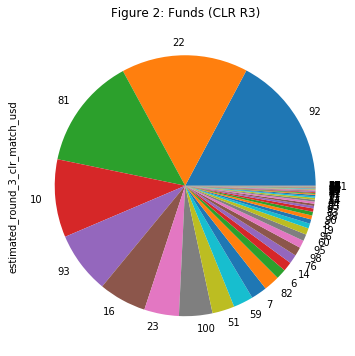

In [7]:
sorted_grants.estimated_round_3_clr_match_usd.plot(kind='pie', title='Figure 2: Funds (CLR R3)', figsize=(13, 6))

Now we have got the dataset ready, and let's move on to explore and answer the questions that we're curious about. 


## Topic 1: Is there a bias towards certain types of projects?

To answer the first question, we'll analyze the distribution of fund v.s. the types of projects. 

The project types are analyzed with the below fields:

1. tags
1. keywords
1. history



### 1. Tags

In the below charts, we calculaed the distribution of funds by tags. There're **10** unique tags in all the grants.  

As show in figure 3 and figure 4, in Gitcoin Grants Round 3 CLR, **All**, **UI/UX** and **Wallet** almost occupied 70% of all the funds, followed by **ETH 2.0**, **Security**, **Community** and **DeFi**, which occupied almost the remaining 30%. 

As a comparison to previous rounds, **Wallet**, **ETH 2.0** and **DeFi** have drawn more attention from the fund contributors, and the portion of **Community** has decreased. 

The correlation of funds by tag are visible when comparing the round 3 and total funds as shown in figure 5.

In [8]:
# get the tag list

tags_list = grants.tags.tolist()
tags = set([tag for grant_tags in tags_list for tag in grant_tags])
tags

{'All',
 'Community',
 'DeFI',
 'ETH 1.x',
 'ETH 2.0',
 'Education',
 'Scalability',
 'Security',
 'UI/UX',
 'Wallets'}

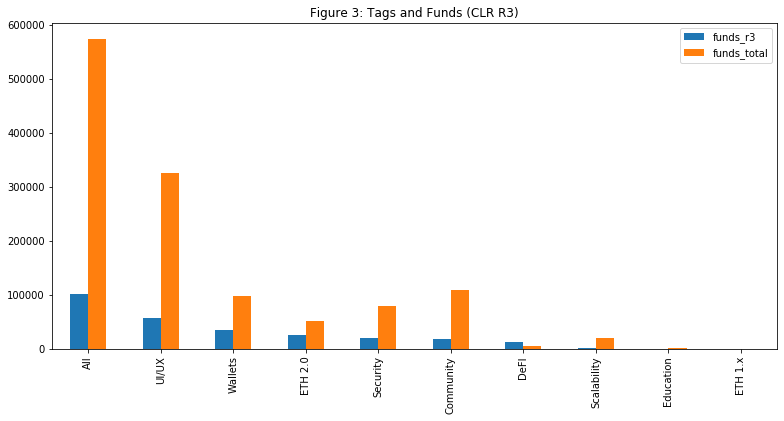

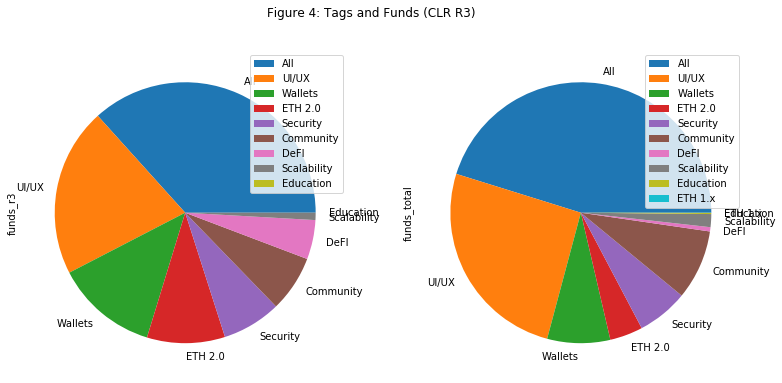

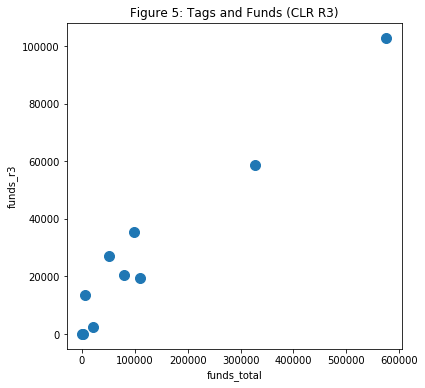

In [9]:
# calculate the fund distribution per tags
funds_r3 = [grants[grants.tags.apply(lambda x: t in x)]['estimated_round_3_clr_match_usd'].sum() for t in tags]
funds_total = [grants[grants.tags.apply(lambda x: t in x)]['total_amount_received_usd_life'].sum() for t in tags]

plot_df = pd.DataFrame({'funds_r3': funds_r3, 'funds_total': funds_total}, index = list(tags))
plot_df = plot_df.sort_values("funds_r3", ascending=False)  # ranked by r3 funds
plot_df.plot(kind='bar', title='Figure 3: Tags and Funds (CLR R3)', figsize=(13, 6))
plot_df.plot(subplots=True, kind='pie', title='Figure 4: Tags and Funds (CLR R3)', figsize=(13, 6))
plot_df.plot(x="funds_total", y="funds_r3", s=100, kind='scatter', title='Figure 5: Tags and Funds (CLR R3)', figsize=(6, 6))

### 2. Keywords

Besides following the tags defined by the Gitcoin community, next we try to extract keywords from the Grants **titles**, and analyze the distribution of funds by keywords. 

We can find that the top 20 keywords are quite different generally if we rank the grants by Round 3 CLR or the total funds. 

The common top keywords are **ethereum**, **development**, **research**, **austin**, and **griffith**, mainly coming from the Grant "[Austin Griffith Ethereum Research and Development](https://gitcoin.co/grants/122/austin-griffith-ethereum-rampd)". Besides, **ehtereum** is among the top keywords that attracts a large number of funds. 

The keywords shift can also be found by comparing the Grants in Round 3 and previous total funds. 

In [10]:
# get the keyword list

grants['keywords'] = grants.title.str.lower().str.replace('\W', ' ').str.split(' ')
keywords = set([k for grant_keywords in grants['keywords'] for k in grant_keywords if len(k) > 1])
exclude_keywords = ["and", "by", "to", "the", "an", "of", "on", "be", "for"]
for k in exclude_keywords:
    if k in keywords:
        keywords.remove(k)
keywords

{'1000',
 '2019',
 '20190522',
 'abridged',
 'adj',
 'africa',
 'aggregator',
 'all',
 'allee',
 'aly',
 'app',
 'asyncio',
 'atomic',
 'audit',
 'augmented',
 'austin',
 'bar',
 'based',
 'better',
 'bias',
 'black',
 'block',
 'blockchain',
 'blockscout',
 'bugs',
 'buidler',
 'building',
 'burner',
 'business',
 'call',
 'cat',
 'chain',
 'chainid',
 'chamber',
 'client',
 'code',
 'codefund',
 'codes',
 'coldoutreach',
 'com',
 'community',
 'complete',
 'connext',
 'consensus',
 'contract',
 'contracts',
 'contributions',
 'core',
 'course',
 'cross',
 'cryptoeconomics',
 'daog',
 'dappnode',
 'dapps',
 'dat',
 'data',
 'decentralize',
 'decentralized',
 'defi',
 'defiprime',
 'deleted',
 'deora',
 'dev',
 'devcon',
 'developer',
 'developers',
 'development',
 'devs',
 'donations',
 'ecosystem',
 'education',
 'eggforce',
 'ended',
 'eth',
 'eth2',
 'ethereum',
 'ethers',
 'ethhub',
 'ethmagicians',
 'evm',
 'evolution',
 'factory',
 'fee',
 'fission',
 'foo',
 'free',
 'full',
 

In [11]:
# calculate the fund distribution per keyword
funds_r3 = [grants[grants.keywords.apply(lambda x: t in x)]['estimated_round_3_clr_match_usd'].sum() for t in keywords]
funds_total = [grants[grants.keywords.apply(lambda x: t in x)]['total_amount_received_usd_life'].sum() for t in keywords]

funds_df = pd.DataFrame({'funds_r3': funds_r3, 'funds_total': funds_total}, index = list(keywords))

# top 20 keywords for previous rounds
previous_keywords = funds_df.sort_values("funds_total", ascending=False)[:20]  # ranked by total funds
previous_keywords

,funds_r3,funds_total
threshold,1.333333,98497.9007
signature,1.333333,98497.9007
toolkit,1.333333,98497.9007
scheme,1.333333,98497.9007
tsskit,1.333333,98497.9007
ethereum,49501.412951,79535.2398
network,4697.316041,48483.2975
app,12.704766,37516.0000
progpow,0.000000,35264.2842
development,16207.220646,33033.1563


In [12]:
# top 20 keywords for round 3
r3_keywords = funds_df.sort_values("funds_r3", ascending=False)[:20]  # ranked by r3 funds
r3_keywords

,funds_r3,funds_total
ethereum,49501.412951,79535.2398
client,18590.303729,24085.2530
lighthouse,17744.885696,21816.6451
development,16207.220646,33033.1563
research,16180.198091,31479.7563
griffith,16156.887492,30854.1563
austin,16156.887492,30854.1563
ethhub,14238.926681,17843.0227
information,14238.926681,17843.0227
hub,14238.926681,17843.0227


In [13]:
# common keywords in top 30 keywords from r3 and total funds
shared_keywords = list(set(previous_keywords.index).intersection(r3_keywords.index))
funds_df[funds_df.index.isin(shared_keywords)].sort_values("funds_r3", ascending=False)

,funds_r3,funds_total
ethereum,49501.412951,79535.2398
development,16207.220646,33033.1563
research,16180.198091,31479.7563
austin,16156.887492,30854.1563
griffith,16156.887492,30854.1563


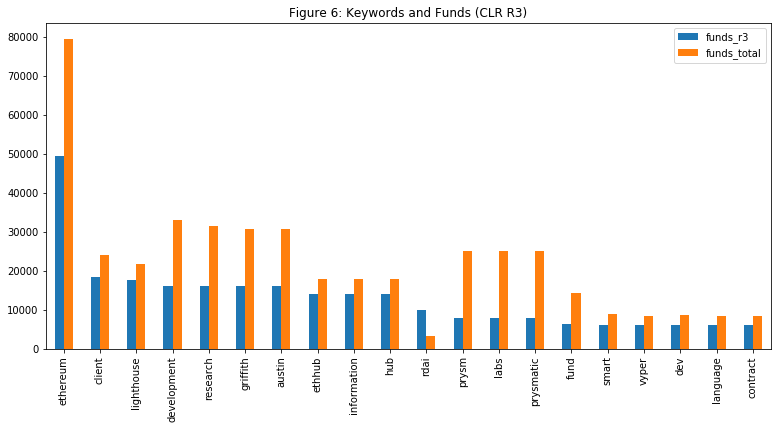

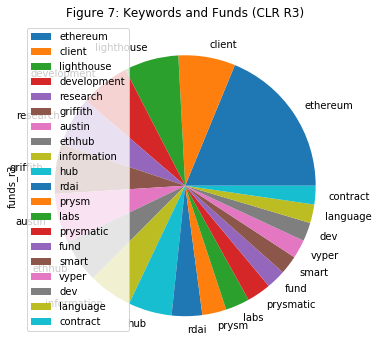

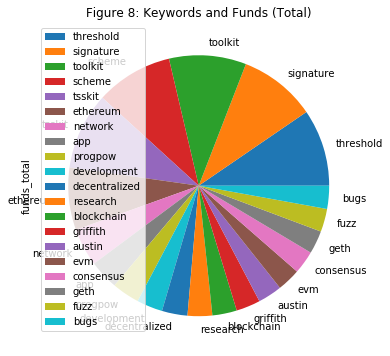

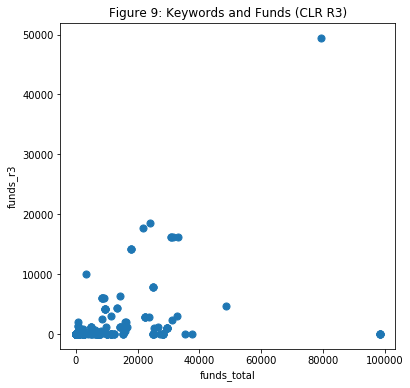

In [14]:
# draw the charts for keywords and funds
plot_df = funds_df.sort_values("funds_r3", ascending=False)[:20]
plot_df.plot(kind='bar', title='Figure 6: Keywords and Funds (CLR R3)', figsize=(13, 6))
plot_df.plot(y="funds_r3", kind='pie', title='Figure 7: Keywords and Funds (CLR R3)', figsize=(13, 6))
plot_df2 = funds_df.sort_values("funds_total", ascending=False)[:20]
plot_df2.plot(y="funds_total", kind='pie', title='Figure 8: Keywords and Funds (Total)', figsize=(13, 6))
funds_df.plot(x="funds_total", y="funds_r3", s=50, kind='scatter', title='Figure 9: Keywords and Funds (CLR R3)', figsize=(6, 6))

### 3. History

The result of Grant contribution in past rounds may impact the result in Round 3. In this section, we show the correlation between Round 3 funds and the total funds of previous rounds. 

The correlation is strong in top, but not apparent if considering all the cases. 

- The 9 out of the top 10 grants in Round 3 CLR have received more than 5000 USD Grants before this round. 
- Quite a few grants that received many grants in total have received quite few grants in Round 3. 
- For the grants that received the least funds this round, much less correlation can be found. 


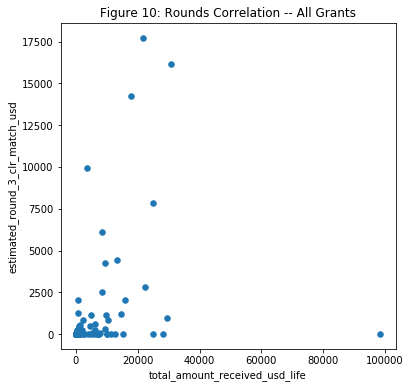

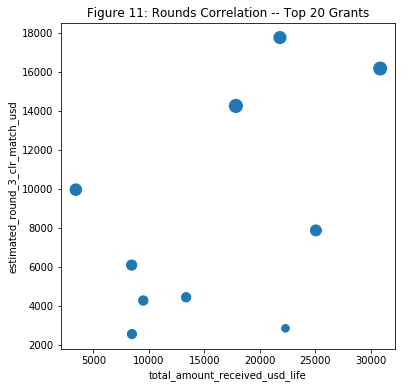

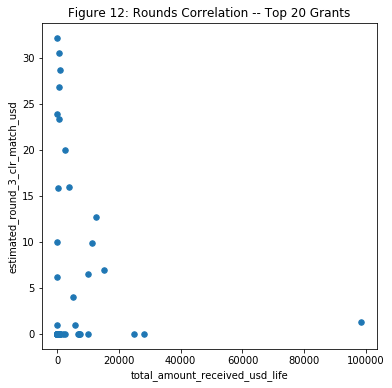

In [15]:
sorted_grants.plot(x="total_amount_received_usd_life", y="estimated_round_3_clr_match_usd", s=30, kind='scatter', title='Figure 10: Rounds Correlation -- All Grants', figsize=(6, 6))
sorted_grants[:10].plot(x="total_amount_received_usd_life", y="estimated_round_3_clr_match_usd", s=sorted_grants["num_of_contributions"], kind='scatter', title='Figure 11: Rounds Correlation -- Top 20 Grants', figsize=(6, 6))
sorted_grants[-60:].plot(x="total_amount_received_usd_life", y="estimated_round_3_clr_match_usd", s=30, kind='scatter', title='Figure 12: Rounds Correlation -- Top 20 Grants', figsize=(6, 6))

## Topic 2: Is there on-chain collusion?

Gitcoin Grants Round 3 CLR makes use of Pairwise Bonding ( https://ethresear.ch/t/pairwise-coordination-subsidies-a-new-quadratic-funding-design/5553 ) to prevent collusion. To verify the results, we're curious to detect whether there're collusion with the latest model applied. 

First, let's explore the contribution data.

There're **2216** contributions, **514** unique contributors and **589** unique IP addresses in total.

We could find that the **top 12** contributions by USD value has already coverd **60%** of the total fund contribution amount.

To investigate the collusion, there're a few strategies we could try:

1. investigate the shared IP addressed by profiles;
1. investigate the pairwise coordination for all the projects


In [16]:
# add grants url and title in contributions

for index, row in grants.iterrows():
    contrib = row['contributions']
    for c in contrib:
        c['grant_title'] = row['title']
        c['grant_url'] = row['url']

In [17]:
# get the contribution list

contributions_list = grants.contributions.tolist()
contributions = pd.DataFrame([c for grant_contributions in contributions_list for c in grant_contributions])
contributions.shape[0]

2216

In [18]:
len(contributions.profile.unique()) # number of profile

514

In [19]:
len(contributions.ip_address.unique()) # number of IP addresses

589

In [20]:
contributions.value_usd.sum()  # total amount of round 3

181009.9736722344

In [21]:
sorted_contributions = contributions.sort_values("value_usd", ascending=False) # sort by usd value
sorted_contributions[:10]

,tx_id,created,value_usd,profile,ip_address,num_tx_approved,pk,grant_title,grant_url
1736,0x45e9fc22914d73000c6420bcb8609bd0f0a8d68515ef...,2019-09-18T23:42:41Z,37500.000,31f546cd4adc0bc0ef383849642742402dce302f0c2d4b...,f913b4571ff96e2c96371f6f5863cfcc258ad873bfa62b...,0,c-1211,Lighthouse: Ethereum 2.0 Client,/grants/25/lighthouse-ethereum-20-client
412,0xc18a8681e06e86a9240560e6ee1c30a5a23a7a590f8c...,2019-09-18T23:05:34Z,12500.000,31f546cd4adc0bc0ef383849642742402dce302f0c2d4b...,f913b4571ff96e2c96371f6f5863cfcc258ad873bfa62b...,0,c-1207,Black Girls CODE x Blockchain Ecosystem,/grants/130/black-girls-code-x-blockchain-ecos...
885,0xc59a97f8e9272824ac6a69a9edf0b3e312684eaa88a7...,2019-09-19T00:44:25Z,12500.000,31f546cd4adc0bc0ef383849642742402dce302f0c2d4b...,f913b4571ff96e2c96371f6f5863cfcc258ad873bfa62b...,0,c-1212,Public Health Incentives Layer App,/grants/118/public-health-incentives-layer-app
784,0xc77f3c7b9fa6f7a28864a204ec97be2d69a40133ccc7...,2019-09-18T23:11:45Z,12500.000,31f546cd4adc0bc0ef383849642742402dce302f0c2d4b...,f913b4571ff96e2c96371f6f5863cfcc258ad873bfa62b...,0,c-1208,Gas Stations Network,/grants/121/gas-stations-network
1571,0x791f8dba175dd7372bf2ecc244f8c293f114b82348cc...,2019-10-02T05:54:37Z,5001.306,51c9a243cec657b8dc5e6629c102c9cbcd5d1fa0c39680...,d99a6ab1b96c84342266ea5b2b1600212721872b1361b2...,0,c-2876,Plasma Group,/grants/39/plasma-group
620,0x5314d5b5efddeb9fe13b980429f89ba3a007f09f8e1c...,2019-10-01T19:23:55Z,5000.000,7bf349a2508166762ae6512f8f2f7e749e01f363a80e7a...,db24e42a536c12bb9a8b0c608905264e0bbd8e67d12777...,5,c-2710,Austin Griffith Ethereum Research and Development,/grants/122/austin-griffith-ethereum-rampd
578,0x4f2cbc43994469a41b8c7cc17b33d034578f61bad857...,2019-09-18T23:17:26Z,5000.000,31f546cd4adc0bc0ef383849642742402dce302f0c2d4b...,f913b4571ff96e2c96371f6f5863cfcc258ad873bfa62b...,0,c-1209,Kickback,/grants/125/kickback
465,0xa2fae6044a553852d90c792715bd9c40247381d4456f...,2019-09-19T00:48:06Z,5000.000,31f546cd4adc0bc0ef383849642742402dce302f0c2d4b...,f913b4571ff96e2c96371f6f5863cfcc258ad873bfa62b...,0,c-1213,Vyper Smart Contract Language Dev Fund,/grants/128/vyper-smart-contract-language-dev-...
868,0x7b573d96756e3747061293653193c19660aea70a3e0c...,2019-09-18T23:22:10Z,5000.000,31f546cd4adc0bc0ef383849642742402dce302f0c2d4b...,f913b4571ff96e2c96371f6f5863cfcc258ad873bfa62b...,0,c-1210,Nori,/grants/120/nori
2006,0xa37ffbf5f2da28b02526e9e0d81d8e86a151c857f1b9...,2019-09-17T01:09:12Z,4500.000,90d3203db8a9dd2acfb98a7552dedb65158d7f9240447f...,ba6144469db252f74a46ff47a61d92cc47eea0bc3e5883...,0,c-1202,fuzz geth and Parity for EVM consensus bugs,/grants/22/fuzz-geth-and-parity-for-evm-consen...


In [22]:
sorted_contributions.describe() # profile

,value_usd,num_tx_approved
count,2216.000000,2216.000000
mean,81.683201,0.496390
std,968.065816,2.688154
min,0.000000,0.000000
25%,1.000000,0.000000
50%,4.750000,0.000000
75%,10.000000,0.000000
max,37500.000000,99.000000


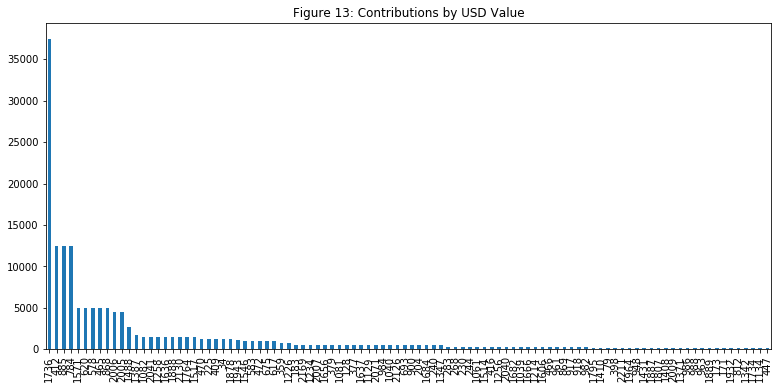

In [23]:
sorted_contributions[:100].value_usd.plot(kind='bar', title='Figure 13: Contributions by USD Value', figsize=(13, 6))

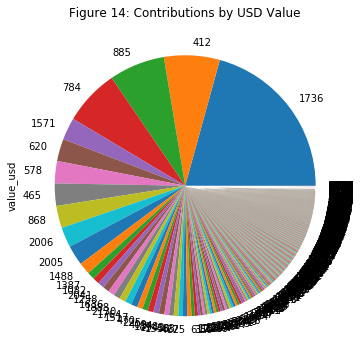

In [24]:
sorted_contributions.value_usd.plot(kind='pie', title='Figure 14: Contributions by USD Value', figsize=(13, 6))

### 1. Shared IP Addresses by Profiles

To investigate the collusion, we start by find the suspicious that might be owned by the same real person or a group of people. The "IP address" field in the Grants dataset is the useful info for such detection. 

As shown by the analysis below, **14** suspecious IP addresses are used by **34** users to make **34** contributions. This brings us a question: is is possible there're 14 people/entities that used the 34 accounts to make exact one contribution by every account? If the answer is yes, why did he/she/they needs to do that? We need to look at details to understand more about the scenarios. 

By linking the IP addresses with grants, we could find **14** groups of grants that are contributed by the same IPs but from different profiles. Further analysis will be needed to understand whether these related grants have valid collusions or not. 



In [25]:
# show the string in table completely
# pd.set_option('display.max_colwidth', -1)

In [26]:
# find shared ip addresses used by multiple profiles

shared_ip_addresses = contributions.groupby('ip_address')['profile'].nunique().sort_values(ascending=False).reset_index(name='used_by_number_of_profiles')
reused_ips = shared_ip_addresses[shared_ip_addresses['used_by_number_of_profiles'] > 1]
reused_ips

,ip_address,used_by_number_of_profiles
0,2ceb75027f1a1132d6cf349ea2bcd918b0f79acdb65c4f...,5
1,d30e74168abe8bc7f46da7b0aa37fb3f42baae203655ec...,4
2,bc9830c1b6b9069d031d4de7b2a07aebcec6dc6d481736...,3
3,a90a49b130403154d5565fb630387b738f00372af06c93...,3
4,9cdf48ad2747d3bcea71f860caaad2abd3ef03f9eab40c...,3
5,0025199914773e7181d49ae767273fec3ba35cf89370ff...,2
6,1cae691baa0c7d52c026f621a9c3b243b805871f86ccca...,2
7,3e5c33d9101609f23bc6c2adf0735c82610b4c14a95c07...,2
8,1be6cf92f7c4f338b400fce2dfc4881b658fdb91be5435...,2
9,bca4837737820f13de156b1a3b3130d9df30119a66627e...,2


In [27]:
# list the contributions that belongs to the IP addresses
reused_ips_list = reused_ips.ip_address.tolist()
suspecious_contributions = contributions[contributions['ip_address'].isin(reused_ips_list)]
len(suspecious_contributions) # suspecious_contributions.sort_values("ip_address")

101

In [28]:
# list the profiles/users that made the suspecious contributions
suspecious_user_list = suspecious_contributions.profile.tolist()
suspecious_profiles_contributions = contributions[contributions.profile.isin(suspecious_user_list)]

suspecious_profiles = suspecious_profiles_contributions.groupby('profile').agg(
    grants=pd.NamedAgg(column="grant_url", aggfunc=list), 
    grants_count=pd.NamedAgg(column="grant_url", aggfunc="count"),
    value_sum_usd=pd.NamedAgg(column="value_usd", aggfunc=sum),
    ip_addr_count=pd.NamedAgg(column="ip_address", aggfunc="nunique")).reset_index()
suspecious_profiles.shape[0] # number of profiles/users that made the suspecious contributions

34

In [29]:
suspecious_profiles.sort_values("grants_count", ascending=False)[:20]

,profile,grants,grants_count,value_sum_usd,ip_addr_count
17,ae03c652db8c8a17ea7a89c0593da5ed6c22598fa7a050...,"[/grants/138/burner-vote, /grants/134/rdai, /g...",19,5.000000,2
10,54356585c9c19db59c4fefd8d157db60bd084fd5218d10...,"[/grants/141/metamoneymarket, /grants/139/defi...",15,212.791739,1
4,24f5374e3bd4898c21084490c34800d86d65fda1d139f7...,"[/grants/80/walletconnect, /grants/48/uniswap,...",8,11536.000000,1
20,b788494e6bee9da8e9a98a2dd568804a3f41339c20fd65...,"[/grants/139/defiprimecom, /grants/138/burner-...",8,5.000000,1
2,1cba63c7b4af42e55476031a8298a396881cace5294d7a...,"[/grants/86/gitcoin-sustainability-fund, /gran...",7,5.000000,2
3,1cdbb56d69d8f2ef39b27c72362de3acf4f806aeed6cd2...,"[/grants/141/metamoneymarket, /grants/134/rdai...",7,52.000000,2
5,2ff3de13149c11eb04273b2a73c80745a8bb848d2f9ec3...,"[/grants/134/rdai, /grants/134/rdai, /grants/1...",7,60.000000,2
27,dbf95001bf0637433b290f4602116ccd7a565ee694888c...,"[/grants/137/nimbus-2, /grants/137/nimbus-2, /...",7,7.501000,1
28,e08742e1dadca61ee3912103bbe305efc01ed21865b6ee...,"[/grants/142/nethermind, /grants/137/nimbus-2,...",7,88.000000,2
22,be336e0060319f5bc61e16550a8744a691bf5f75cf802e...,"[/grants/138/burner-vote, /grants/133/abridged...",5,5.000000,1


In [30]:
# list the suspecious grants from the same IP address
urls = suspecious_contributions.grant_url.tolist()
suspecious_grants = grants[grants['url'].isin(urls)]
len(suspecious_grants)

34

In [31]:
# group the grants by ip addresses
grants_from_same_IPs = suspecious_contributions.groupby('ip_address')['grant_title'].transform(lambda x: ' | '.join(set(x)))
suspecious_contributions['related_grants'] = grants_from_same_IPs
related_grants = suspecious_contributions[['ip_address', 'related_grants']].drop_duplicates()
related_grants

/Users/robort/.local/share/virtualenvs/grants-IlLAhYhd/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ip_address,related_grants
6,0025199914773e7181d49ae767273fec3ba35cf89370ff...,rDAI | defiprime.com | DeFi Tutorials
27,19e97561f3539bced16365b8fe20ba14b808eb17f88af4...,fuzz geth and Parity for EVM consensus bugs | ...
49,9cdf48ad2747d3bcea71f860caaad2abd3ef03f9eab40c...,MetaMoneyMarket | Black Girls CODE x Blockchai...
107,1cae691baa0c7d52c026f621a9c3b243b805871f86ccca...,Block Rewards Funding Working Group | Vyper Sm...
114,a90a49b130403154d5565fb630387b738f00372af06c93...,Burner Vote | Abridged | Austin Griffith Ether...
162,d30e74168abe8bc7f46da7b0aa37fb3f42baae203655ec...,EthHub - Ethereum Information Hub | Burner Vot...
267,3e5c33d9101609f23bc6c2adf0735c82610b4c14a95c07...,Gas Stations Network | Vyper Smart Contract La...
306,bca4837737820f13de156b1a3b3130d9df30119a66627e...,rDAI | Zero Knowledge Podcast | ZoKrates | Aus...
373,81028cb4a8c6fdf74240fc4dff026abf26dff71fda4ff2...,Abridged | Plasma Group | Cryptoeconomics.stud...
919,087c21903b2f0cbbb623b106dc7b4ee2ed507f31420016...,Tasit - mobile Ethereum dapps


In [32]:
len(related_grants) # number of group of related grants

14

### 2. Pairwise Coordination

In this section, we'll analyze the paired contributors that appear in the grants, and understand how they interact in the Gitcoin Grants system, and potentially offline relationship. 

We first analyze the contributions made by each profile/user, and then find the users have the most number of shared grants in their contributions. 

As analyzed, **102** pairs of contributors have more than 10 shared grants in Gitcoin Grants Round 3 CLR. 

To look into more detials, we find that the top 1 pair profiles (`5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1db96af800b` and `775fec778ed2672f511d864e139552a3690de36a93de3a8733773678`), shared **34 grants** in their contribution (more than 1/3 of the total number of grants). The two users are ranked top 2 by the number of grants they contributed (73 and 53 respectively). The interesting part is that `5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1db96af800b` has granted 25K+ USD in total, while `775fec778ed2672f511d864e139552a3690de36a93de3a8733773678` has granted 5 USD in total for 53 projects, with 0.0943 USD for each contribution evenly, within 4 or 5 hours. We need extra info about this user to understand why he/she/it behaves like this. 




In [33]:
# find shared ip addresses used by multiple profiles

profiles = contributions.groupby('profile').agg(
    grants=pd.NamedAgg(column="grant_url", aggfunc=list), 
    grants_count=pd.NamedAgg(column="grant_url", aggfunc="count"),
    value_sum_usd=pd.NamedAgg(column="value_usd", aggfunc=sum)).reset_index()
profiles.shape[0]

514

In [34]:
profiles.sort_values("grants_count", ascending=False)[:20] # users ranked by grants count

,profile,grants,grants_count,value_sum_usd
190,5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1...,"[/grants/143/dappnode, /grants/142/nethermind,...",73,25196.977898
250,775fec778ed2672f511d864e139552a3690de36a93de3a...,"[/grants/144/defi-tutorials, /grants/143/dappn...",53,5.000000
34,10e1468140889d420db74e5094c16e900b079b8f6b16c2...,"[/grants/139/defiprimecom, /grants/137/nimbus-...",37,3467.500000
156,490b4f749b03dbd8ca74c29138ec3516c24a9fed5b64b6...,"[/grants/145/burner-wallet-2-burner-factory, /...",29,719.821567
483,ed949020e67fd59ae5b4818795af4489f76bc0b6a12a4d...,"[/grants/145/burner-wallet-2-burner-factory, /...",28,68.000000
40,177255c080165073e085e574d8c41ef4496622cfc96bee...,"[/grants/134/rdai, /grants/132/the-dat-protoco...",27,31.000000
302,8ffc7d30fc002b0ea9a7669698d38916766e294520135d...,"[/grants/141/metamoneymarket, /grants/139/defi...",23,34.000000
305,90d3203db8a9dd2acfb98a7552dedb65158d7f9240447f...,"[/grants/137/nimbus-2, /grants/132/the-dat-pro...",22,11540.000000
83,295fe90b4018210b943bc6d9d8d6bac915bea736211546...,"[/grants/137/nimbus-2, /grants/134/rdai, /gran...",21,763.300000
386,bb20eb2d31a36795ff529ea00b8491e3f3ff35ab537c15...,"[/grants/141/metamoneymarket, /grants/134/rdai...",20,199.000000


In [35]:
paired_contributors_list = []
for index1, row1 in profiles.iterrows():
    for index2, row2 in profiles.iterrows():
        if index2 > index1: # avoid duplicate
            shared_grants = list(set(row1['grants']).intersection(row2['grants']))
            if len(shared_grants) > 0:
                paired_contributors_list.append({
                    "profile1": row1['profile'],
                    "profile2": row2['profile'],
                    "shared_grants": shared_grants,
                    "shared_grants_count": len(shared_grants)
                })
paired_contributors = pd.DataFrame(paired_contributors_list)
paired_contributors = paired_contributors.sort_values("shared_grants_count", ascending=False)
paired_contributors.shape[0] # number of paired contributors

41305

In [36]:
paired_contributors.head() # top contributor pairs, ranked by shared_grants_count

,profile1,profile2,shared_grants,shared_grants_count
24455,5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1...,775fec778ed2672f511d864e139552a3690de36a93de3a...,[/grants/22/fuzz-geth-and-parity-for-evm-conse...,34
5383,10e1468140889d420db74e5094c16e900b079b8f6b16c2...,5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1...,[/grants/22/fuzz-geth-and-parity-for-evm-conse...,25
5436,10e1468140889d420db74e5094c16e900b079b8f6b16c2...,775fec778ed2672f511d864e139552a3690de36a93de3a...,[/grants/22/fuzz-geth-and-parity-for-evm-conse...,25
20516,490b4f749b03dbd8ca74c29138ec3516c24a9fed5b64b6...,5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1...,[/grants/22/fuzz-geth-and-parity-for-evm-conse...,22
24675,5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1...,ed949020e67fd59ae5b4818795af4489f76bc0b6a12a4d...,[/grants/22/fuzz-geth-and-parity-for-evm-conse...,21


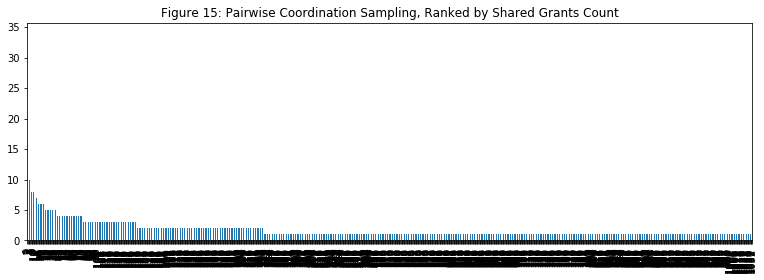

In [37]:
paired_contributors_sample = pd.Series(paired_contributors.shared_grants_count.tolist()[::40])
paired_contributors_sample.plot(kind="bar", title="Figure 15: Pairwise Coordination Sampling, Ranked by Shared Grants Count", figsize=(13, 4)) # contributor pairs, ranked by shared_grants_count

In [38]:
suspecious_paired_contributors = paired_contributors[paired_contributors["shared_grants_count"] > 10]
len(suspecious_paired_contributors) # the contributor pairs that have more than 10 shared grants

102

### 3. Combine Shared IP Addresses and Pairwise Coordination

By combing results of the above two kinds of analysis towards shared IP addresses and paired contributors, we can narrow down the investigation to find issues faster. By looking at the intersection of the users from the above two analysis, we found the below two profiles may worth investigation first: `ae03c652db8c8a17ea7a89c0593da5ed6c22598fa7a050210c5feb16` and `54356585c9c19db59c4fefd8d157db60bd084fd5218d10c754f46b55`.

profile	| grants_count | value_sum_usd | ip_addr_count
:-- | -- | -- | --
ae03c652db8c8a17ea7a89c0593da5ed6c22598fa7a050210c5feb16 | 19 | 5.000000 | 2
54356585c9c19db59c4fefd8d157db60bd084fd5218d10c754f46b55 | 15 | 212.791739 | 1 


In [39]:
# intersections of the user list from shared IP addresses and paired contributors
shared_ip_addr_user_list = set(suspecious_profiles.profile.tolist())
paired_contributor_user_list = set(suspecious_paired_contributors.profile1.tolist() + suspecious_paired_contributors.profile2.tolist())
intersected_user_list = list(shared_ip_addr_user_list.intersection(paired_contributor_user_list))

common_contributions = contributions[contributions.profile.isin(intersected_user_list)]

common_profiles = common_contributions.groupby('profile').agg(
    grants=pd.NamedAgg(column="grant_url", aggfunc=list), 
    grants_count=pd.NamedAgg(column="grant_url", aggfunc="count"),
    value_sum_usd=pd.NamedAgg(column="value_usd", aggfunc=sum),
    ip_addr_count=pd.NamedAgg(column="ip_address", aggfunc="nunique")).reset_index()
common_profiles.sort_values("grants_count", ascending=False)

,profile,grants,grants_count,value_sum_usd,ip_addr_count
1,ae03c652db8c8a17ea7a89c0593da5ed6c22598fa7a050...,"[/grants/138/burner-vote, /grants/134/rdai, /g...",19,5.000000,2
0,54356585c9c19db59c4fefd8d157db60bd084fd5218d10...,"[/grants/141/metamoneymarket, /grants/139/defi...",15,212.791739,1


## Summary

In this project, we worked on analyzing the GitCoin Grants Round 3 CLR dataset to understand how the mechanism of CLR works, and how it demonstrates the value of the mechanism, and what's the major issues it faces and how to improve. 

Below are some clusions about the research. 

We tried to answer the questions about (1) the **bias** in the contribution, and (2) the possible **collusion** that we can found by analyzing IP addressed and paired contributions. 


### Bias Analysis

It's interesting to learn about the patterns/trends especially the bias, in the CLR grants/contributions, to understand how this mechanism works, and pros/cons of this design.

1. When Liberal Radicalism is designed for public good, the bias we found in **tags, keywords, and history**, do reflect its intention to **support the community's public good**. The focus on the "Ethereum" related keywords demonstrated the shared public benefits of the community, but it also indicates that the Gitcoin community may not be active to fund open source projects in a broader and general space of open source projects outside the Ethereum and blockchain world. 

2. The distribution of the funds are quite skewed and showed the **competition nature** of the Grants CLR practice. Only the projects that really matter to the "Ethereum" community will be provided with effective funds. However, we need to add further analysis about the impact of the project team leads, etc. to understand how the fund contribution are impacted.


### Collusion Analysis

We do find interesting clues for collusion analyisis, and further analysis could be done to confirm the details. 

1. By grouping the contributions from the same IP address, but submitted from multiple profiles, we could find **14** suspecious IP addresses are used by **34** users to make **34** contributions. This brings us a question: is is possible there're 14 people/entities that used the 34 accounts to make exact one contribution by every account? If the answer is yes, why did he/she/they needs to do that? Besides, we need to analyze the **14** groups of grants that are possibly related to each other. 

1. In the pairwise coordination, it's interesting to find quite a few pair of profiles/users have apparent shared interests in grants. **102** pairs of contributors have more than 10 shared grants in Gitcoin Grants Round 3 CLR. By looking into more detials, we find that the top 1 pair profiles (`5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1db96af800b` and `775fec778ed2672f511d864e139552a3690de36a93de3a8733773678`), shared **34 grants** in their contribution (more than 1/3 of the total number of grants). The two users are ranked top 2 by the number of grants they contributed (73 and 53 respectively). The interesting part is that `5b35dfc38e8523fe86422a9a12524ae02bc8d40448a4a1db96af800b` has granted 25K+ USD in total, while `775fec778ed2672f511d864e139552a3690de36a93de3a8733773678` has granted 5 USD in total for 53 projects, with 0.0943 USD for each contribution evenly, within 4 to 5 hours.

1. By combing results of the above two kinds of analysis towards shared IP addresses and paired contributors, we can narrow down the investigation to find issues faster. By looking at the intersection of the users from the above two analysis, we found the below two profiles may worth investigation first: `ae03c652db8c8a17ea7a89c0593da5ed6c22598fa7a050210c5feb16` and `54356585c9c19db59c4fefd8d157db60bd084fd5218d10c754f46b55`.


For more details, check the Jupyter Notebook to learn more.



## Future Plan

Add more data sources

1. We need to incorporate more data from Gitcoin activities to understand the behaviors of the users. 
1. More datasets about the activities data on social media, GitHub, etc. of the projects leads and fund contributors are necessary to analyze the bias towards social impact and the do further investigation about the offchain collusion.

Generalize the research

1. Apply the same model of CLR data analysis to more areas of public good, in order to improve the mechanism and strategy of CLR. 